In [221]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn

import jax.nn.initializers as init

from functools import partial

from tqdm.auto import tqdm

## Data Generation

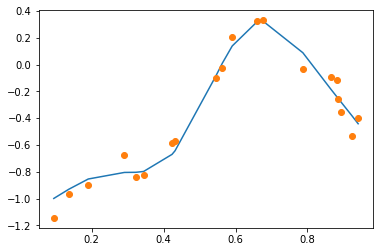

In [164]:

def get_data(size, sigma=0.1, noise=0.1):
    
    x = random.uniform(0,1,size=size)
    x = np.sort(x)
    
    X,XT = np.meshgrid(x,x)
    d = (X - XT)**2

    cov = np.exp(-d / sigma**2) 
    mu = np.zeros(size)

    y = random.multivariate_normal(mu,cov)
    
    n = random.normal(size=size)*noise

    return x, y,y+n, cov


x,y,yn, cov = get_data(20,0.3)
plt.plot(x,y)
plt.plot(x,yn,'o')

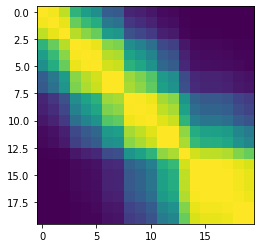

In [166]:
plt.imshow(cov)

In [128]:
cov.shape

(20, 20)

## GP

In [215]:
class GP(nn.Module):
    
    num_inducing_pts: int 
    num_dims: int = 0
        
    mu: float = 0
        
    init_ls: float = 0.1
    init_ks: float = 0.1
        
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)
    
    def setup(self):
        
        
        # Generative Parameters
#         self.ls = self.param('likelihood_variance',lambda _: self.init_ls)
#         self.ks = self.param('kernel_variance',lambda _: self.init_ks)
        self.ls = self.init_ls
        self.ks = self.init_ks
        
        if self.num_dims == 0:
            Z = jnp.linspace(0,1,self.num_inducing_pts)
        else:
            shape = (self.num_inducing_pts,) if self.num_dims == 0 else (self.num_inducing_pts, self.num_dims)
            Z = jax.random.uniform(self.key,shape=shape)
            
        S = self.get_k()[0](Z,Z)

        # Variational Parameters
        self.Z = self.param('inducing_points',lambda _: Z)
        self.m = self.param('mean',init.zeros,(self.num_inducing_pts,))
        self.S = self.param('covariance',lambda _: S)
        
                                
    def __call__(self,X):
        
        pass
                       
        
    def get_k(self):
        
        if self.num_dims == 0:
            k = lambda x, xp: jnp.exp( -(x - xp)**2 / (2 * self.ks) )
        else:
            k = lambda x, xp: jnp.exp( -jnp.sum((x - xp)**2,axis=-1) / (2 * self.ks) )

        K = jax.vmap(jax.vmap(k,(0,None),0),(None,0),1)
        kv = jax.vmap(k,(0,None),0)
        return K,kv,k
        
    def elbo(self,X,Y):
        
        # Calculate means and variances
        K,kv,k = self.get_k()
        Kuu = K(self.Z,self.Z)
        Kuu_inv = jnp.linalg.inv(Kuu)
        
        @jax.vmap
        def mu_and_var(x):
            
            ku = kv(self.Z,x).T
            mu = self.mu + ku @ Kuu_inv @ (self.m - self.mu)
            var = k(x,x) + ku @ Kuu_inv @ (self.S - Kuu) @ Kuu_inv @ ku.T
            
            return mu, var
            
        mu, var = mu_and_var(X)
        
        # expected log liklihood
        L = jnp.log(1/jnp.sqrt(2*jnp.pi)*self.ls) - ((Y - mu)**2 + var) / (2 * self.ls)
        L = jnp.sum(L)

        
        # KL - divergence
        
        def kl(m1,S1,m2,S2):
            
            S2inv = jnp.linalg.inv(S2)
            
            t = jnp.log(jnp.linalg.det(S2)/jnp.linalg.det(S1)) + jnp.trace(S2inv @ S1) + (m1-m2) @ S2inv @ (m1-m2) - self.num_inducing_pts
            return t/2
        
        KL = kl(self.m,self.S, self.mu, Kuu)
        
#         print(f'L: {L}')
#         print(f'KL: {KL}')
        
        return L - KL
            

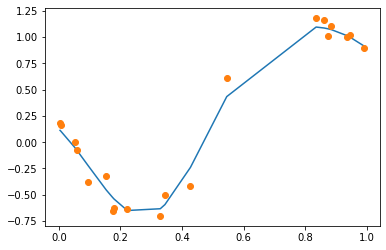

In [246]:
X,Y,Yn,_ = get_data(20,0.4)

plt.plot(X,Y)
plt.plot(X,Yn,'o')

In [258]:
key = jax.random.PRNGKey(5)

gp = GP(10,init_ks=0.001,key=key)
params = gp.init(key,X,Y,method=gp.elbo)

elbo = partial(gp.apply,X=X,Y=Y,method=gp.elbo)

grad_fn = jax.jit(jax.grad(elbo))

In [274]:
lr = 0.00005

num_iters = 1000

pbar = tqdm(range(num_iters))

for _ in pbar:
    
    pbar.set_description(f'ELBO: {elbo(params) :.2f}')
    
    grads = grad_fn(params)
    
    params = jax.tree_multimap(
          lambda p, g: p + lr * g, params, grads
      )
    

  0%|          | 0/1000 [00:00<?, ?it/s]

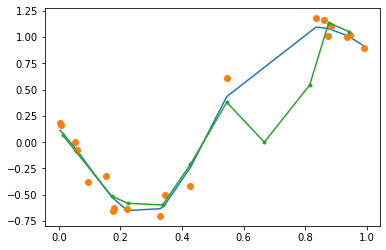

In [273]:
S = params['params']['covariance']
m = params['params']['mean']
Z = params['params']['inducing_points']

plt.plot(X,Y)
plt.plot(X,Yn,'o')
plt.plot(Z,m,'.-')